<a href="https://colab.research.google.com/github/yeshwanthkonk/TelecomChurnPrediction_HybridModel_UVIC_503/blob/main/Churn_Prediction_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Loading


In [ ]:
import pandas as pd
import json
import numpy as np
import os
import random
import torch

from google.colab import drive
drive.mount('/content/drive')

# load dataset from CSV
df = pd.read_csv('/content/drive/MyDrive/Collab_Files/Churn_Prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')
X = df.drop(columns="Churn")
y = df["Churn"]
y = y.map({'Yes': 1, 'No': 0})

with open("/content/drive/MyDrive/Collab_Files/Churn_Prediction/cross_validation_split.json", "r") as f:
    cv_data = json.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_all_seeds()

## Data Partition

In [ ]:
folds = cv_data["folds"]
test_indices = cv_data["test_indices"]

## Data Processing

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

def encode_data(df, df_y, ordinal):
  # Drop extraneous columns
  df = df.drop(columns=[c for c in ['Phone','Churn','customerID'] if c in df.columns])

  # Convert false objects to float
  df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

  if ordinal:
    df["Contract"] = df["Contract"].map({"Month-to-month": 0, "One year": 1, "Two year": 2})

  # Drop Missing Value + and drop those rows for labels
  original_index = df.index
  df = df.dropna()
  dropped_idx = original_index.difference(df.index)
  df_y = df_y.drop(index=dropped_idx)

  # Get categorical columns (excluding customerID which is just an identifier)
  categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

  # Create a copy of the dataframe for encoding and remove null data
  df_encoded = df.copy()

  # Method 1: Label Encoding for binary categorical variables
  binary_categorical = []
  multi_categorical = []

  # Identify binary vs multi-category variables
  for col in categorical_cols:
      unique_values = df[col].nunique()
      if unique_values == 2:
          binary_categorical.append(col)
      else:
          multi_categorical.append(col)

  # Apply Label Encoding to binary categorical variables
  label_encoders = {}
  for col in binary_categorical:
      le = LabelEncoder()
      df_encoded[col] = le.fit_transform(df[col])
      label_encoders[col] = le

  # Method 2: One-Hot Encoding for multi-categorical variables
  if multi_categorical:
      df_encoded = pd.get_dummies(df_encoded, columns=multi_categorical, prefix=multi_categorical, drop_first=True)

  bool_cols = df_encoded.select_dtypes(include='bool').columns
  df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

  return df_encoded, df_y

def scale_data(train_np, test_np):
  # Apply Min-Max scaling to range [-1, 1]
  scaler = MinMaxScaler(feature_range=(-1, 1))
  train_scaled_np = scaler.fit_transform(train_np)
  test_scaled_np = scaler.transform(test_np)

  return train_scaled_np, test_scaled_np

X, y = encode_data(X, y, False)
X = X.values
y = y.values

## Model Initialization

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report

class SimpleNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, dataloader, epochs):
    best_loss = float('inf')
    patience_counter = 0
    model.train()

    for epoch in range(epochs):
        # Track total loss of epoch
        total_loss = 0.0
        for xb, yb in dataloader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        # Average loss of epoch
        avg_loss = total_loss / len(dataloader)

        # Check if model has converged
        if avg_loss < best_loss - 1e-4:
          best_loss = avg_loss
          patience_counter = 0
        else:
          patience_counter += 1
          if patience_counter >= 15:
            #print(f"Early stopping at epoch {epoch + 1}")
            break

    return model

def evaluate_model(model, x, y, print_cm):
    model.eval()
    with torch.no_grad():
        y_pred_logits = model(x)
        y_pred_probs = torch.sigmoid(y_pred_logits)
        #y_pred_probs = model(x)
        y_pred = (y_pred_probs >= 0.5).int()

    y_true = y.cpu().numpy().astype(int)
    y_pred = y_pred.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)
    if print_cm:
      print("Confusion Matrix:")
      print(cm)

    return accuracy, recall, f1

def model_classification_report(model, x, y):
    model.eval()
    with torch.no_grad():
        y_pred_logits = model(x)
        y_pred_probs = torch.sigmoid(y_pred_logits)
        y_pred = (y_pred_probs >= 0.5).int()

    y_true = y.cpu().numpy().astype(int)
    y_pred = y_pred.cpu().numpy()

    print("Classification Report:")
    print(classification_report(y_true, y_pred))


def downsample(X, y):
  class0_indices = np.where(y == 0)[0]
  class1_indices = np.where(y == 1)[0]

  # Calculate the number of samples to keep for each class
  num_samples_to_keep = min(len(class0_indices), len(class1_indices))

  # Randomly select indices from each class
  class0_sampled = np.random.choice(class0_indices, num_samples_to_keep, replace=False)
  class1_sampled = np.random.choice(class1_indices, num_samples_to_keep, replace=False)

  # Combine the sampled indices
  balanced_idx = np.concatenate([class0_sampled, class1_sampled])
  np.random.shuffle(balanced_idx)

  # Create the balanced dataset
  X_balanced = X[balanced_idx]
  y_balanced = y[balanced_idx]

  return X_balanced, y_balanced

## Cross Validation

In [ ]:
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
from sklearn.metrics import f1_score, recall_score
features = list(range(X.shape[1]))
accuracies = []
f1s = []
recalls = []

for fold in tqdm(range(len(folds))):
  # Partition Fold
  train_idx = folds[fold][0]
  val_idx = folds[fold][1]

  # Get train set Indices and put into dataloader
  X_train = X[train_idx][:, features]
  y_train = y[train_idx]

  # Try to downsample X_train
  X_train, y_train = downsample(X_train, y_train)

  X_val = X[val_idx][:, features]
  y_val = y[val_idx]

  # Scale Data using only train set
  X_train_scaled, X_val_scaled = scale_data(X_train, X_val)

  X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

  subset = TensorDataset(X_train_tensor, y_train_tensor)
  dataloader = DataLoader(subset, batch_size=512, shuffle=True)

  # Validation set to tensor
  X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

  # Weighted loss
  weight = len(y_train) / (2 * sum(y_train))
  pos_weight = torch.tensor([1]).to(device)
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
  model = SimpleNet(len(features)).to(device)
  optimizer = optim.Adam(model.parameters(), lr=1e-2)

  # Train model
  model = train_model(model, criterion, optimizer, dataloader, epochs=10000)

  # Evaluate Network
  accuracy, recall, f1 = evaluate_model(model, X_val_tensor, y_val_tensor, True)

  accuracies.append(accuracy)
  f1s.append(f1)
  recalls.append(recall)


 20%|██        | 1/5 [00:07<00:28,  7.11s/it]

Confusion Matrix:
[[577 259]
 [ 51 238]]


 40%|████      | 2/5 [00:09<00:12,  4.14s/it]

Confusion Matrix:
[[543 265]
 [ 62 255]]


 60%|██████    | 3/5 [00:11<00:06,  3.41s/it]

Confusion Matrix:
[[564 255]
 [ 66 240]]


 80%|████████  | 4/5 [00:15<00:03,  3.64s/it]

Confusion Matrix:
[[595 239]
 [ 70 221]]


100%|██████████| 5/5 [00:20<00:00,  4.20s/it]

Confusion Matrix:
[[574 266]
 [ 49 236]]


In [ ]:
# Print average accuracy, recall and f1
print("Average Accuracy: ", np.mean(accuracies))
print("Average Recall: ", np.mean(recalls))
print("Average F1: ", np.mean(f1s))

# Print Std of accuracy recall and f1
print("Std Accuracy: ", np.std(accuracies))
print("Std Recall: ", np.std(recalls))
print("Std F1: ", np.std(f1s))

Average Accuracy:  0.7187555555555555
Average Recall:  0.7999559776600587
Average F1:  0.6004924738760062
Std Accuracy:  0.006044444444444442
Std Recall:  0.025500630082527852
Std F1:  0.007053062374175341


## Feature Importance


In [ ]:
good_features = list(range(X.shape[1]))  # Start with all features
best_recall = 0

# pick one fold as the validation fold
i = random.randint(0, 4)
train_idx = folds[i][0]
val_idx = folds[i][1]
max_iters = 10

for i in range(max_iters):
  print(good_features)
  print(best_recall)
  recalls = np.zeros(len(good_features))

  for j, feature in enumerate(good_features):
    features = good_features.copy()
    features.remove(feature)

    # Skip if no features left
    if len(features) == 0:
      continue

    # get only those features (train and val)
    X_train = X[train_idx][:, features]
    y_train = y[train_idx]

    X_val = X[val_idx][:, features]
    y_val = y[val_idx]

    #X_train, y_train = downsample(X_train, y_train)

    # Scale Data using only train set
    X_train_scaled, X_val_scaled = scale_data(X_train, X_val)

    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

    subset = TensorDataset(X_train_tensor, y_train_tensor)
    dataloader = DataLoader(subset, batch_size=32, shuffle=True)

    # Reinitialize the model and optimizer
    model = SimpleNet(len(features)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)

    # Train model
    model = train_model(model, criterion, optimizer, dataloader, epochs=1000)

    # Evaluate Network Train
    accuracy, recall, f1 = evaluate_model(model, X_train_tensor, y_train_tensor, False)

    # log recall
    recalls[j] = recall

  if max(recalls) > best_recall:
    best_recall = max(recalls)
    worst_index = np.argmax(recalls)
    feature_to_remove = good_features[worst_index]
    good_features.remove(feature_to_remove)
  else:
    break

# Found that we only need features: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
0
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
0.6889074228523769


## Learning Curves

In [ ]:
import random

repetitions = 3
partition_sizes = np.linspace(0.1, 1, 10)

validation_errors = np.zeros((repetitions, len(partition_sizes)))
training_errors = np.zeros((repetitions, len(partition_sizes)))

# pick one fold as the validation fold
i = random.randint(0,4)
train_idx = folds[i][0]
val_idx = folds[i][1]

# Validation set to tensor
X_val = X[val_idx]
y_val = y[val_idx]


for p in tqdm(range(len(partition_sizes))):
  for r in range(repetitions):
    # randomly sample p% of train set
    train_size = int(partition_sizes[p] * len(train_idx))
    train_idx_sample = random.sample(list(train_idx), train_size)

    # Put data into tensors
    X_train = X[train_idx_sample]
    y_train = y[train_idx_sample]
    #X_train, y_train = downsample(X_train, y_train)

    # Scale Data using only train set
    X_train_scaled, X_val_scaled = scale_data(X_train, X_val)

    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

    subset = TensorDataset(X_train_tensor, y_train_tensor)
    dataloader = DataLoader(subset, batch_size=32, shuffle=True)

    # Reinitialize the model and optimizer for each train size
    model = SimpleNet(X.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)

    weight = len(y_train) / (2 * sum(y_train))
    pos_weight = torch.tensor([1]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Train model
    model = train_model(model, criterion, optimizer, dataloader, epochs=1000)

    # Evaluate Network Train
    accuracy, recall, f1 = evaluate_model(model, X_train_tensor, y_train_tensor, False)
    training_errors[r, p] = 1 - accuracy

    # Evaluate Network Val
    accuracy, recall, f1 = evaluate_model(model, X_val_tensor, y_val_tensor, False)
    validation_errors[r, p] = 1 - accuracy

100%|██████████| 10/10 [07:39<00:00, 45.91s/it]


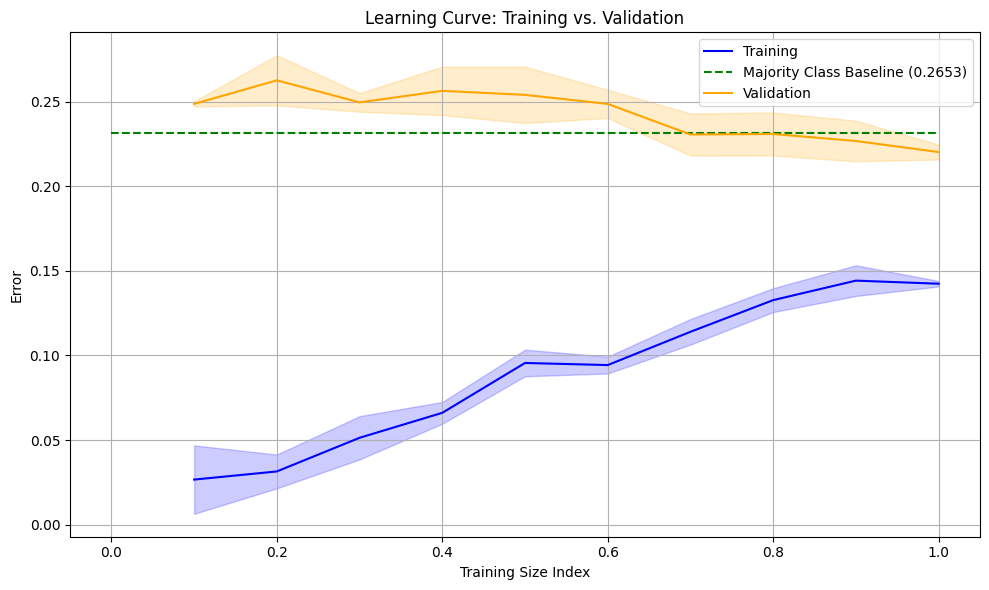

In [ ]:
import matplotlib.pyplot as plt

train_mean = np.mean(training_errors, axis=0)
train_std = np.std(training_errors, axis=0)

val_mean = np.mean(validation_errors, axis=0)
val_std = np.std(validation_errors, axis=0)

x = partition_sizes

plt.figure(figsize=(10, 6))

# Plot training curve
plt.plot(x, train_mean, label="Training", color="blue")
plt.fill_between(x, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)

plt.hlines(0.2317, xmin = 0, xmax = 1, label= "Majority Class Baseline (0.2653)", linestyles='dashed', colors='green')

# Plot validation curve
plt.plot(x, val_mean, label="Validation", color="orange")
plt.fill_between(x, val_mean - val_std, val_mean + val_std, color="orange", alpha=0.2)

plt.xlabel("Training Size Index")
plt.ylabel("Error")
plt.title("Learning Curve: Training vs. Validation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Final Training and Evaluation on Test Set

In [ ]:
# Get all train indices
train_indices = folds[1][0] + folds[1][1]

X_train = X[train_indices]
y_train = y[train_indices]

X_test = X[test_indices]
y_test = y[test_indices]

X_train, y_train = downsample(X_train, y_train)

# Scale Data using only train set
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

subset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(subset, batch_size=32, shuffle=True)

# Reinitialize the model and optimizer for each train size
model = SimpleNet(X.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

weight = len(y_train) / (2 * sum(y_train))
pos_weight = torch.tensor([1]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Train model
model = train_model(model, criterion, optimizer, dataloader, epochs=1000)

# Evaluate Model
accuracy, recall, f1 = evaluate_model(model, X_test_tensor, y_test_tensor, False)

model_classification_report(model, X_test_tensor, y_test_tensor)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1026
           1       0.50      0.79      0.61       381

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



## Export Model

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Collab_Files/Churn_Prediction/best_NN.pkl')